This code comes mostly from this Q-learning educational video: 
https://www.youtube.com/watch?v=nSxaG_Kjw_w

In [43]:
import numpy as np
import pylab as plt
import networkx as nx

In [44]:
#state transition capababilities

edges_list = [(0,1), (1,5), (5,6), (5,4), (1,2), (2,3), (2,7),  
              (8,3), (8,5), (8,4), (9,4), (9,8), (9,3), (9,6),
              (1,8), (1,3), (0,4), (0,6), (10,8), (10,2), (10,6),
              (2,11), (2,12), (2,13), (2,14), (13,14), (13,12),
              (2,15), (2,16), (2,17), (2,18), (2,19), (2,20)]

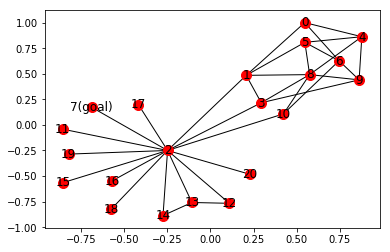

In [8]:
#visualize the connections

G = nx.Graph()
G.add_edges_from(edges_list)
mapping={7:'7(goal)'}
H=nx.relabel_nodes(G, mapping)
pos = nx.spring_layout(H)
nx.draw_networkx_nodes(H, pos, node_size=[100])
nx.draw_networkx_edges(H, pos)
nx.draw_networkx_labels(H, pos)
plt.show()

In [19]:
#There is a reward Matrix R
#There is a Q-value Matrix Q (a matrix that represents best estimates of the present value of future rewards)

#survey possible actions
def available_actions(state):
    current_state_row = R[state,]
    #negative numbers are used to define states that are not accessible
    av_act = np.where(current_state_row >= 0)[0] #tutorial has index 1 but maybe that's because Reward matrix R is wrapped in matrix?
    return av_act

#randomly choose a possible action
def sample_next_action(available_act): 
    next_action = int(np.random.choice(available_act,1)) #maybe should have ,1 to make it an array?
    return next_action

#based on latest action and reward feedback, update your assesment of the value of that action (i.e. Expected Future Reward Per Time Period metric)
#at time 1 (after action and reward), revalue from time 0 (before action and reward)
def update(current_state, action, discount_factor):
    
    #now look ahead given that you're in the next state. take note of which action you think has the highest payoff
    max_index = np.where(Q[action,] == np.max(Q[action,]))[0]  #tutorial has index 1 but maybe that's because R is wrapped in matrix?
    
    if max_index.shape[0] > 1: #if two actions seem to be equally good in terms of future payoffs
        max_index = int(np.random.choice(max_index, size = 1)) #randomly choose one (it won't matter because they're equal in assessment)
    else:
        max_index = int(max_index) 
        
    expected_remaining_present_value = Q[action, max_index] #current assesment of the PV of future expected returns going forward

    #There is an implicit weighting of 1 here since we don't blend the old Q-value estimate in with a learning rate
    Q[current_state, action] = R[current_state, action] + discount_factor*expected_remaining_present_value #Bellman Equation
    print('An updated assessment of being in state', current_state, 'and taking action to go to state ', action,' is: ', Q[current_state, action])
    
    return(np.sum(Q)) #jdk's score metric

In [20]:
#define the states of the system

goal = 7 #state 7 is the goal

#state transition reward matrix size (0-20)
#Q matrix size
matrix_size = 21

#define the reward matrix for actions/moves from various states to other various states

#initialize Rewards Matrix
R = np.ones((matrix_size, matrix_size))
R = R*-1 #since our actions will take a max over transition possibilities, the -1s act as out-of-bounds

for path in edges_list: #a path is a state transition pair
    if path[1] == goal: #if the end state/point in this path is the goal
        R[path] = 100 #the reward for the action of moving from state i to end state j(goal) is 100
    else:
        R[path] = 0 #all other actions/paths get no reward
        
    #going in the opposite direction
    #we assume that if you can go from state i to state j, you can go from state j to state i
    if path[0] == goal: #if the beginning state i is the goal
        R[(path[1], path[0])] = 100 #the action of moving from state j to state i is 100
    else:
        R[(path[1], path[0])] = 0 #all other reverse action/paths get no reward
        

#allow for the possibility to stay in the final goal state
#the value of being in the goal state will move to a perpetuity value of Reward/(1-discount factor)
#not important to allow other states to loop since it just wastes exploration time
R[goal,goal] = 100

In [38]:
#see Reward Matrix
print(R)

[[ -1.   0.  -1.  -1.   0.  -1.   0.  -1.  -1.  -1.  -1.  -1.  -1.  -1.
   -1.  -1.  -1.  -1.  -1.  -1.  -1.]
 [  0.  -1.   0.   0.  -1.   0.  -1.  -1.   0.  -1.  -1.  -1.  -1.  -1.
   -1.  -1.  -1.  -1.  -1.  -1.  -1.]
 [ -1.   0.  -1.   0.  -1.  -1.  -1. 100.  -1.  -1.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.]
 [ -1.   0.   0.  -1.  -1.  -1.  -1.  -1.   0.   0.  -1.  -1.  -1.  -1.
   -1.  -1.  -1.  -1.  -1.  -1.  -1.]
 [  0.  -1.  -1.  -1.  -1.   0.  -1.  -1.   0.   0.  -1.  -1.  -1.  -1.
   -1.  -1.  -1.  -1.  -1.  -1.  -1.]
 [ -1.   0.  -1.  -1.   0.  -1.   0.  -1.   0.  -1.  -1.  -1.  -1.  -1.
   -1.  -1.  -1.  -1.  -1.  -1.  -1.]
 [  0.  -1.  -1.  -1.  -1.   0.  -1.  -1.  -1.   0.   0.  -1.  -1.  -1.
   -1.  -1.  -1.  -1.  -1.  -1.  -1.]
 [ -1.  -1.   0.  -1.  -1.  -1.  -1. 100.  -1.  -1.  -1.  -1.  -1.  -1.
   -1.  -1.  -1.  -1.  -1.  -1.  -1.]
 [ -1.   0.  -1.   0.   0.   0.  -1.  -1.  -1.   0.   0.  -1.  -1.  -1.
   -1.  -1.  -1.  -1.  -1.  -1.  -1.]
 [ -1.  -1

In [39]:
#Initialize the Expected Future Rewards Per Period Given you're in state i and take action to go to state j(the Q_uality of action)
Q = np.zeros((matrix_size, matrix_size))

discount_factor = 0.8 #discount factor in the Bellman Equation

#Training

scores = []

for i in range(1500):
    current_state = np.random.randint(0, int(Q.shape[0]))
    available_act = available_actions(current_state)
    action = sample_next_action(available_act)
    score = update(current_state, action, discount_factor)
    scores.append(score)
    print('The overall Q-Matrix value metric: ', str(score))
    
print('Trained Q matrix:')
print(Q)

An updated assessment of being in state 3 and taking action to go to state  1  is:  0.0
The overall Q-Matrix value metric:  0.0
An updated assessment of being in state 3 and taking action to go to state  9  is:  0.0
The overall Q-Matrix value metric:  0.0
An updated assessment of being in state 1 and taking action to go to state  0  is:  0.0
The overall Q-Matrix value metric:  0.0
An updated assessment of being in state 16 and taking action to go to state  2  is:  0.0
The overall Q-Matrix value metric:  0.0
An updated assessment of being in state 17 and taking action to go to state  2  is:  0.0
The overall Q-Matrix value metric:  0.0
An updated assessment of being in state 2 and taking action to go to state  16  is:  0.0
The overall Q-Matrix value metric:  0.0
An updated assessment of being in state 7 and taking action to go to state  7  is:  100.0
The overall Q-Matrix value metric:  100.0
An updated assessment of being in state 15 and taking action to go to state  2  is:  0.0
The over

An updated assessment of being in state 18 and taking action to go to state  2  is:  268.92800000000005
The overall Q-Matrix value metric:  9131.209830400003
An updated assessment of being in state 18 and taking action to go to state  2  is:  268.92800000000005
The overall Q-Matrix value metric:  9131.209830400003
An updated assessment of being in state 3 and taking action to go to state  9  is:  137.69113600000006
The overall Q-Matrix value metric:  9268.900966400004
An updated assessment of being in state 10 and taking action to go to state  8  is:  172.11392000000006
The overall Q-Matrix value metric:  9268.900966400004
An updated assessment of being in state 7 and taking action to go to state  7  is:  432.8911360000001
The overall Q-Matrix value metric:  9285.678182400003
An updated assessment of being in state 11 and taking action to go to state  2  is:  268.92800000000005
The overall Q-Matrix value metric:  9285.678182400003
An updated assessment of being in state 4 and taking ac

An updated assessment of being in state 8 and taking action to go to state  3  is:  292.5122093056001
The overall Q-Matrix value metric:  14133.500375695365
An updated assessment of being in state 3 and taking action to go to state  9  is:  182.8097674444801
The overall Q-Matrix value metric:  14144.196223139845
An updated assessment of being in state 10 and taking action to go to state  6  is:  172.11392000000006
The overall Q-Matrix value metric:  14144.196223139845
An updated assessment of being in state 3 and taking action to go to state  2  is:  365.6402616320001
The overall Q-Matrix value metric:  14144.196223139845
An updated assessment of being in state 16 and taking action to go to state  2  is:  365.6402616320001
The overall Q-Matrix value metric:  14144.196223139845
An updated assessment of being in state 13 and taking action to go to state  12  is:  292.5122093056001
The overall Q-Matrix value metric:  14221.566032445444
An updated assessment of being in state 11 and taking

An updated assessment of being in state 11 and taking action to go to state  2  is:  365.6402616320001
The overall Q-Matrix value metric:  16356.432309102842
An updated assessment of being in state 5 and taking action to go to state  4  is:  187.20781395558407
The overall Q-Matrix value metric:  16356.432309102842
An updated assessment of being in state 2 and taking action to go to state  17  is:  292.5122093056001
The overall Q-Matrix value metric:  16433.802118408443
An updated assessment of being in state 20 and taking action to go to state  2  is:  365.6402616320001
The overall Q-Matrix value metric:  16433.802118408443
An updated assessment of being in state 17 and taking action to go to state  2  is:  365.6402616320001
The overall Q-Matrix value metric:  16433.802118408443
An updated assessment of being in state 12 and taking action to go to state  13  is:  292.5122093056001
The overall Q-Matrix value metric:  16433.802118408443
An updated assessment of being in state 14 and taki

The overall Q-Matrix value metric:  17446.001496104524
An updated assessment of being in state 9 and taking action to go to state  8  is:  234.00976744448008
The overall Q-Matrix value metric:  17446.001496104524
An updated assessment of being in state 16 and taking action to go to state  2  is:  396.31065118525817
The overall Q-Matrix value metric:  17446.001496104524
An updated assessment of being in state 2 and taking action to go to state  12  is:  292.5122093056001
The overall Q-Matrix value metric:  17446.001496104524
An updated assessment of being in state 11 and taking action to go to state  2  is:  396.31065118525817
The overall Q-Matrix value metric:  17446.001496104524
An updated assessment of being in state 1 and taking action to go to state  0  is:  187.20781395558407
The overall Q-Matrix value metric:  17446.001496104524
An updated assessment of being in state 17 and taking action to go to state  2  is:  396.31065118525817
The overall Q-Matrix value metric:  17476.6718856

The overall Q-Matrix value metric:  18935.168576704156
An updated assessment of being in state 16 and taking action to go to state  2  is:  396.31065118525817
The overall Q-Matrix value metric:  18935.168576704156
An updated assessment of being in state 15 and taking action to go to state  2  is:  396.31065118525817
The overall Q-Matrix value metric:  18935.168576704156
An updated assessment of being in state 2 and taking action to go to state  10  is:  317.04852094820654
The overall Q-Matrix value metric:  18935.168576704156
An updated assessment of being in state 8 and taking action to go to state  10  is:  317.04852094820654
The overall Q-Matrix value metric:  18959.704888346765
An updated assessment of being in state 18 and taking action to go to state  2  is:  396.31065118525817
The overall Q-Matrix value metric:  18959.704888346765
An updated assessment of being in state 19 and taking action to go to state  2  is:  396.31065118525817
The overall Q-Matrix value metric:  18959.7048

An updated assessment of being in state 2 and taking action to go to state  3  is:  317.04852094820654
The overall Q-Matrix value metric:  19390.790150934045
An updated assessment of being in state 16 and taking action to go to state  2  is:  396.31065118525817
The overall Q-Matrix value metric:  19390.790150934045
An updated assessment of being in state 5 and taking action to go to state  6  is:  234.00976744448008
The overall Q-Matrix value metric:  19390.790150934045
An updated assessment of being in state 4 and taking action to go to state  0  is:  202.9110534068522
The overall Q-Matrix value metric:  19406.493390385313
An updated assessment of being in state 2 and taking action to go to state  10  is:  317.04852094820654
The overall Q-Matrix value metric:  19406.493390385313
An updated assessment of being in state 12 and taking action to go to state  2  is:  396.31065118525817
The overall Q-Matrix value metric:  19406.493390385313
An updated assessment of being in state 20 and tak

An updated assessment of being in state 15 and taking action to go to state  2  is:  396.31065118525817
The overall Q-Matrix value metric:  20028.004216005273
An updated assessment of being in state 7 and taking action to go to state  2  is:  396.31065118525817
The overall Q-Matrix value metric:  20028.004216005273
An updated assessment of being in state 15 and taking action to go to state  2  is:  396.31065118525817
The overall Q-Matrix value metric:  20028.004216005273
An updated assessment of being in state 7 and taking action to go to state  7  is:  498.48884272548185
The overall Q-Matrix value metric:  20028.382005323903
An updated assessment of being in state 20 and taking action to go to state  2  is:  396.31065118525817
The overall Q-Matrix value metric:  20028.382005323903
An updated assessment of being in state 1 and taking action to go to state  5  is:  253.63881675856524
The overall Q-Matrix value metric:  20094.813008126883
An updated assessment of being in state 7 and tak

An updated assessment of being in state 4 and taking action to go to state  8  is:  253.63881675856524
The overall Q-Matrix value metric:  20256.355634892352
An updated assessment of being in state 16 and taking action to go to state  2  is:  396.31065118525817
The overall Q-Matrix value metric:  20256.355634892352
An updated assessment of being in state 5 and taking action to go to state  4  is:  202.9110534068522
The overall Q-Matrix value metric:  20256.355634892352
An updated assessment of being in state 10 and taking action to go to state  6  is:  253.63881675856524
The overall Q-Matrix value metric:  20256.355634892352
An updated assessment of being in state 5 and taking action to go to state  1  is:  317.04852094820654
The overall Q-Matrix value metric:  20256.355634892352
An updated assessment of being in state 2 and taking action to go to state  1  is:  317.04852094820654
The overall Q-Matrix value metric:  20339.394388396075
An updated assessment of being in state 2 and takin

An updated assessment of being in state 18 and taking action to go to state  2  is:  399.8377407231709
The overall Q-Matrix value metric:  20919.450853900267
An updated assessment of being in state 15 and taking action to go to state  2  is:  399.8377407231709
The overall Q-Matrix value metric:  20919.450853900267
An updated assessment of being in state 17 and taking action to go to state  2  is:  399.8377407231709
The overall Q-Matrix value metric:  20919.450853900267
An updated assessment of being in state 5 and taking action to go to state  6  is:  253.63881675856524
The overall Q-Matrix value metric:  20919.450853900267
An updated assessment of being in state 20 and taking action to go to state  2  is:  399.8377407231709
The overall Q-Matrix value metric:  20919.450853900267
An updated assessment of being in state 18 and taking action to go to state  2  is:  399.8377407231709
The overall Q-Matrix value metric:  20919.450853900267
An updated assessment of being in state 18 and takin

An updated assessment of being in state 13 and taking action to go to state  12  is:  319.8961540628294
The overall Q-Matrix value metric:  21071.993819845666
An updated assessment of being in state 15 and taking action to go to state  2  is:  399.93353860021085
The overall Q-Matrix value metric:  21071.993819845666
An updated assessment of being in state 18 and taking action to go to state  2  is:  399.93353860021085
The overall Q-Matrix value metric:  21072.057165867336
An updated assessment of being in state 2 and taking action to go to state  7  is:  499.93353860021085
The overall Q-Matrix value metric:  21072.07378121729
An updated assessment of being in state 0 and taking action to go to state  6  is:  255.8961540628294
The overall Q-Matrix value metric:  21072.07378121729
An updated assessment of being in state 12 and taking action to go to state  13  is:  319.8961540628294
The overall Q-Matrix value metric:  21072.07378121729
An updated assessment of being in state 4 and taking

An updated assessment of being in state 11 and taking action to go to state  2  is:  399.9468308801687
The overall Q-Matrix value metric:  21095.90105138626
An updated assessment of being in state 12 and taking action to go to state  13  is:  319.8961540628294
The overall Q-Matrix value metric:  21095.90105138626
An updated assessment of being in state 6 and taking action to go to state  9  is:  255.91692325026352
The overall Q-Matrix value metric:  21095.90105138626
An updated assessment of being in state 19 and taking action to go to state  2  is:  399.9468308801687
The overall Q-Matrix value metric:  21095.90105138626
An updated assessment of being in state 11 and taking action to go to state  2  is:  399.9468308801687
The overall Q-Matrix value metric:  21095.90105138626
An updated assessment of being in state 20 and taking action to go to state  2  is:  399.9468308801687
The overall Q-Matrix value metric:  21095.90105138626
An updated assessment of being in state 16 and taking act

An updated assessment of being in state 16 and taking action to go to state  2  is:  399.9468308801687
The overall Q-Matrix value metric:  21103.118040076355
An updated assessment of being in state 12 and taking action to go to state  2  is:  399.9468308801687
The overall Q-Matrix value metric:  21103.118040076355
An updated assessment of being in state 9 and taking action to go to state  8  is:  255.96597176330798
The overall Q-Matrix value metric:  21103.118040076355
An updated assessment of being in state 19 and taking action to go to state  2  is:  399.9468308801687
The overall Q-Matrix value metric:  21103.118040076355
An updated assessment of being in state 19 and taking action to go to state  2  is:  399.9468308801687
The overall Q-Matrix value metric:  21103.118040076355
An updated assessment of being in state 19 and taking action to go to state  2  is:  399.9468308801687
The overall Q-Matrix value metric:  21103.118040076355
An updated assessment of being in state 2 and taking

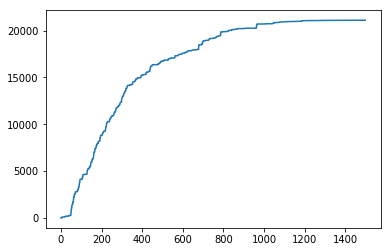

In [40]:
plt.plot(scores)
plt.show()

In [41]:
#the max Q-Value should be associated with the state-action pair (goal, goal)
#max Q-value is a the value of a $100 perpetuity associated with just staying in the goal state
print('Q-Value should converge to: ', 100/(1-discount_factor))
print('Q-Value in goal state after updates: ', Q[7,7])

Q-Value should converge to:  500.0000000000001
Q-Value in goal state after updates:  499.986062034251


In [42]:
#Testing
#See the recommended, quickest path to the goal(only reward) implied by the train Q-value assessments

current_state = np.random.randint(0, int(Q.shape[0]))

#initialize the list that will log the sequence of steps
steps = [current_state]

while current_state != 7:
    next_step_index = np.where(Q[current_state] == np.max(Q[current_state]))[0] 
    
    if next_step_index.shape[0] > 1:
        next_step_index = int(np.random.choice(next_step_index, size = 1))
    else:
        next_step_index = int(next_step_index)
        
    steps.append(next_step_index)
    current_state = next_step_index
    
print("The trained Q-Value Matrix says the best course of action is:")
print(steps)


The trained Q-Value Matrix says the best course of action is:
[0, 1, 2, 7]


Q-learning without neural networks can only take you so far when the number of states in a system is large.

For example, imagine training an agent to explore video game play...
The number of video game states, where a "state" depends on, say, 4 consecutive video frames of 84x84 pixels is:

=256^(4*84*84) >> atoms in the universe

This assumes each pixel is grayscale with 256 possibile shades. It would be worse with RGB channels (256^3).

And this is just the number of states.  
You'd want to explore all possible actions from each state many times to better refine your Q-value estimates.